In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import logging
from pathlib import Path

import numpy as np
import pandas as pd
import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.rats.saturated_relu import SaturatedReLU
from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH


#### Load data and preprocess

In [4]:
data = DataClass(config)

fpath = glob.glob(os.path.join(data.data_path, "rats_data/amap*/*/*.csv"))
df = None

for f in fpath:
    temp = pd.read_csv(f)

    participant = f.split("/")[-3]
    temp["participant"] = participant

    temp = temp[temp.channel1_segment.isna()].copy()

    temp["method"] = temp.channel2_laterality

    if df is None:
        df = temp.copy()
    else:
        df = pd.concat([df, temp], ignore_index=True).copy()

df.reset_index(drop=True, inplace=True)

df, encoder_dict = data.build(df)

# df = df[df.participant.isin([0])].copy()
# df = df[df.compound_position.isin([0, 1])].copy()
# df.reset_index(drop=True, inplace=True)

2023-05-23 10:31:55,890 - hb_mep.data_access.core - INFO - Processing data ...
2023-05-23 10:31:55,946 - hb_mep.utils.utils - INFO - func:preprocess took: 0.06 sec
2023-05-23 10:31:55,946 - hb_mep.utils.utils - INFO - func:build took: 0.06 sec


#### Plot data

In [5]:
# plot(df, encoder_dict=encoder_dict);

#### Initialize model

In [6]:
model = SaturatedReLU(config)

#### Run MCMC inference

In [7]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-05-23 10:31:56,168 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-23 10:31:56,169 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-23 10:31:56,169 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-23 10:31:56,170 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-23 10:31:56,170 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-05-23 10:31:56,204 - hb_mep.models.rats.saturated_relu - INFO - Running inference with Saturat

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-23 10:48:52,694 - hb_mep.utils.utils - INFO - func:run_inference took: 16 min and 56.53 sec


#### Diagnostics

In [8]:
mcmc.print_summary()


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
             a[0,0,0]    121.26      4.35    122.01    114.81    127.79   3284.36      1.00
             a[0,0,1]     46.61      1.11     46.80     45.05     48.19   9458.62      1.00
             a[0,0,2]     38.95      4.60     40.04     32.67     44.51   3699.41      1.00
             a[0,0,3]     13.61      4.07     13.82      6.77     20.09   7411.72      1.00
             a[0,0,4]     33.11      2.20     33.37     29.33     36.42   8627.97      1.00
             a[0,0,5]    105.43     10.91    106.23     89.34    123.28   3689.11      1.00
             a[0,1,0]    185.51     49.32    185.57    106.68    268.18  13108.80      1.00
             a[0,1,1]    174.46     55.21    174.71     82.78    264.95  14171.05      1.00
             a[0,1,2]    180.36     67.86    180.67     62.03    287.16  11370.57      1.00
             a[0,1,3]     78.90     50.36     72.41      0.06    147.49  16710.

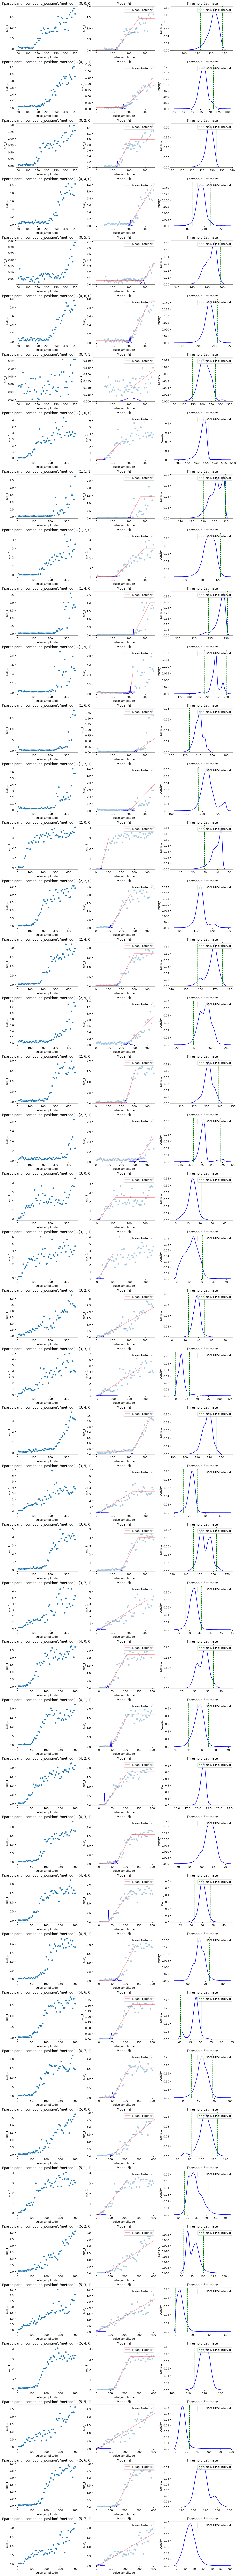

In [9]:
model.plot(df=df, posterior_samples=posterior_samples);